In [1]:
import os
import shutil
import pandas as pd
import holidays
from time import time
from datetime import date, datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from varname.helpers import Wrapper

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Aggregated demand data

In [3]:
def to_datetime(df, col_name):
    try:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d.%m.%Y', utc=True))
        df.index = df.index.tz_convert('Europe/Berlin').tz_localize(None) 
    except:
        df.index = pd.to_datetime(df.index, utc = True).tz_convert('Europe/Berlin').tz_localize(None) 
    df.index = df.index.date
    df.index = pd.to_datetime(df.index) 
    return df.index

## BDEW (calculated from ENTSO-G, corrected with destatis)

In [4]:
bdew = pd.read_csv(os.path.join(data_path, "bdew.csv"), index_col =0)
bdew.index = to_datetime(bdew, " ")
bdew = (bdew / (10**9)).rename(columns={"Verbrauch":"bdew [TWh]"})

## Trading Hub Europe: SLPs & RLMs

THE original data

In [5]:
#read
the = pd.read_csv(os.path.join(data_path, "THE.csv"), sep=";")
the_new = pd.read_csv(os.path.join(data_path, "THE_new.csv"), sep=";")
the = pd.concat([the,the_new], axis=0)
#to datetime 
the.index = to_datetime(the, "Gastag")

#to numeric
the = the.iloc[:, 1:-1].fillna("0")
the = the.iloc[::-1] 
the = the.apply(lambda x: x.apply(lambda y: float(y.replace(".", ""))))

#from kWh to TWh
the = the / (10**9)

In [6]:
the

,SLPsyn H-Gas,SLPana H-Gas,SLPsyn L-Gas,SLPana L-Gas,RLMmT H-Gas,RLMmT L-Gas,RLMoT H-Gas,RLMoT L-Gas
2022-03-26,0.681527,0.143239,0.161804,0.045260,1.036863,0.157409,0.065493,0.001049
2022-03-27,0.676323,0.143501,0.168343,0.046465,1.103991,0.165799,0.071192,0.001346
2022-03-28,0.662072,0.141925,0.172246,0.042433,1.324239,0.195137,0.070385,0.006134
2022-03-29,0.702096,0.149897,0.185236,0.042082,1.441942,0.201032,0.075353,0.008418
2022-03-30,0.874278,0.164445,0.232764,0.044528,1.514027,0.209893,0.082094,0.006044
...,...,...,...,...,...,...,...,...
2022-04-03,1.441127,2.070306,0.322442,0.091454,2.400311,0.197700,0.081540,0.001288
2022-04-04,1.377123,1.961675,0.306160,0.089841,1.382980,0.240107,0.079219,0.001768
2022-04-05,1.126829,1.889768,0.252085,0.078807,1.361270,0.223108,0.084784,0.004265
2022-04-06,0.870789,2.085945,0.207068,0.084073,1.230607,0.216864,0.069367,0.002314


Gas pool data from: https://www.tradinghub.eu/de-de/Download/Archiv-GASPOOL / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [7]:
gaspool = pd.read_csv(os.path.join(data_path, "gaspool.csv"), sep=";")
gaspool.index = to_datetime(gaspool, "Datum")
gaspool.drop("Datum", 1, inplace=True)

#from MWh to TWh
gaspool = gaspool / (10**6)

NCG data from:https://www.tradinghub.eu/de-de/Download/Archiv-NetConnect-Germany / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [8]:
#in KWh
ncg = pd.read_csv(os.path.join(data_path, "ncg.csv"), sep=";")
ncg.index = to_datetime(ncg, "DayOfUse")

ncg.drop(["DayOfUse", "Status"], 1, inplace=True)
ncg.drop(list(ncg.filter(like='Unit', axis=1).columns), 1, inplace=True)

#from kWh to TWh
ncg = ncg / (10**9)

In [9]:
def get_df_name(df):
    return [x for x in globals() if globals()[x] is df][0]

def return_summed_df(df, domain, name):
    return df[df.filter(like=domain, axis=1).columns].sum(1).to_frame().rename(
    columns={0:"{}_{} [TWh]".format(domain, name)})

def sum_consumptions(df):    
    name = get_df_name(df)
    return return_summed_df(df, "SLP", name), return_summed_df(df, "RLM", name) 

def sum_single_col_dfs(df_1, df_2, slp_sum=True, **alternative_name):
    if slp_sum==False:
        name = alternative_name.values()
        return (df_1.iloc[:,0] + df_2.iloc[:,0]).to_frame().rename(columns={
            0:name}) 
    else: 
        name = get_df_name(df_1).split("_")[0]
        return (df_1.iloc[:,0] + df_2.iloc[:,0]).to_frame().rename(columns={
            0:"{}_sum [TWh]".format(name)})

In [10]:
the_slp, the_rlm = sum_consumptions(the)
gaspool_slp, gaspool_rlm = sum_consumptions(gaspool)
ncg_slp, ncg_rlm = sum_consumptions(ncg)

the_sum = sum_single_col_dfs(the_slp, the_rlm)
gaspool_sum = sum_single_col_dfs(gaspool_slp, gaspool_rlm)
ncg_sum = sum_single_col_dfs(ncg_slp, ncg_rlm)

before_the_slp = sum_single_col_dfs(gaspool_slp, ncg_slp).loc[gaspool_slp.index]
before_the_rlm = sum_single_col_dfs(gaspool_rlm, ncg_rlm).loc[gaspool_slp.index]
before_the_sum = sum_single_col_dfs(ncg_sum, gaspool_sum, slp_sum=False, 
                                    alternative_name="aggregated_gaspool_ngc").loc[gaspool_slp.index]

the_whole_slp = pd.concat([the_slp, before_the_slp], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_slp"})
the_whole_rlm = pd.concat([the_rlm.iloc[:,0], before_the_rlm], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_rlm"})
the_whole_sum = pd.concat([the_sum, before_the_sum], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_sum"})

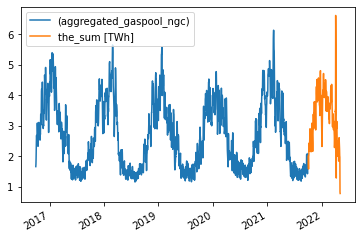

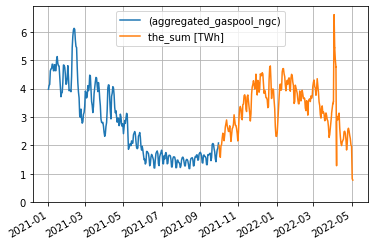

In [11]:
series_all = pd.concat([before_the_sum, the_sum], axis=0)
series_all.plot()
series_all["2021-01-01":].plot(ylim=0)
plt.grid()

In [12]:
the_whole_slp[the_whole_slp.index.year==2020].sum()

the_combined_slp    379.140945
dtype: float64

## THE-BDEW comparison

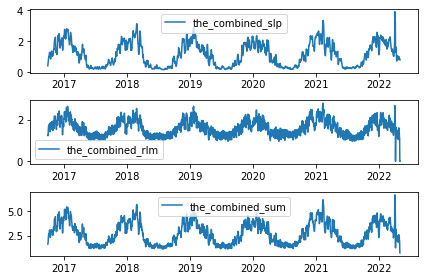

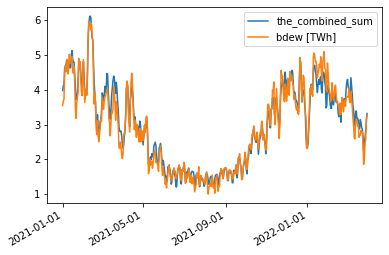

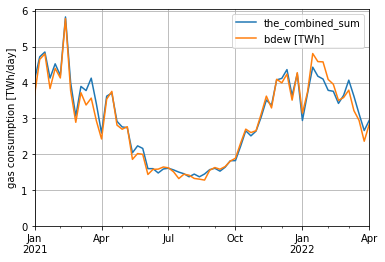

In [13]:
fig, axs = plt.subplots(3)

df_list = [the_whole_slp, the_whole_rlm, the_whole_sum]

for i, df in enumerate(df_list):
    axs[i].plot(df.index, df.iloc[:,0], label=df.columns[0])
    axs[i].legend()
    plt.tight_layout()

ax = the_whole_sum.loc[bdew.index].plot()
bdew.plot(ax=ax)
ax.set_xticks(ax.get_xticks()[::2])

pd.concat([the_whole_sum, bdew], axis=1).dropna().resample('1w').mean().plot(ylim=0).set_ylabel("gas consumption [TWh/day]")
plt.grid()

plt.show()

##Über & danach Unterschätzung 

In [14]:
common_date = bdew.iloc[0].name
bdew_sum = bdew.loc[bdew.index>common_date].sum()[0]
the_sum_sum = the_whole_sum.loc[the_whole_sum.index>common_date].sum()[0]

print("Energy consumption since: {}".format(common_date.strftime("%Y-%m-%d")) + "\n" +
      "the [TWh]: "+ str(the_sum_sum) + "\n" +
      "bdew [TWh]: "+ str(bdew_sum) + "\n" +
      "delta [%]: " + str(100 * (the_sum_sum - bdew_sum )/ 
                    the_sum_sum)
                        ) 

Energy consumption since: 2021-01-01
the [TWh]: 1496.5612527819999
bdew [TWh]: 1336.471390021
delta [%]: 10.69718078450878


# Proxies / control variables / disaggregated demand
## Estimated SLP

In [15]:
estimated = pd.read_csv(os.path.join(data_path, "SLPs_new.csv"), index_col="time")
estimated.index = to_datetime(estimated, " ")

In [16]:
estimated["commercial"] = estimated[["commercial_space TWh", "commercial_water TWh"]].sum(1)
estimated["residential"] = estimated[["residential_space TWh", "residential_water TWh"]].sum(1)

Gas consumption accoriding to AGEB in decentralized units will be mostly small CHP and hence temperature dependent. THis increases overall temperature-dependent gas consumption from 384 to 396 TWh.

In [17]:
estimated["scaled_space_private"] = estimated['residential'] * 254 / estimated['residential'][
    estimated.index.year==2020].sum()

estimated["scaled_space_tertiary"] = estimated['commercial'] * 98 / estimated['commercial'][
    estimated.index.year==2020].sum()

estimated["scaled_decentral_chp"] = estimated['commercial'] * 15 / estimated['commercial'][
    estimated.index.year==2020].sum()

estimated["scaled_space_industry"] = estimated['commercial'] * 25 / estimated['commercial'][
    estimated.index.year==2020].sum()

estimated["scaled_district_heat"] = estimated['dist_heat'] * 19 / estimated['dist_heat'][
    estimated.index.year==2020].sum()

estimated['aggregated(incl_small_chp)'] = estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry","scaled_district_heat"]
                                                   ].sum(1)


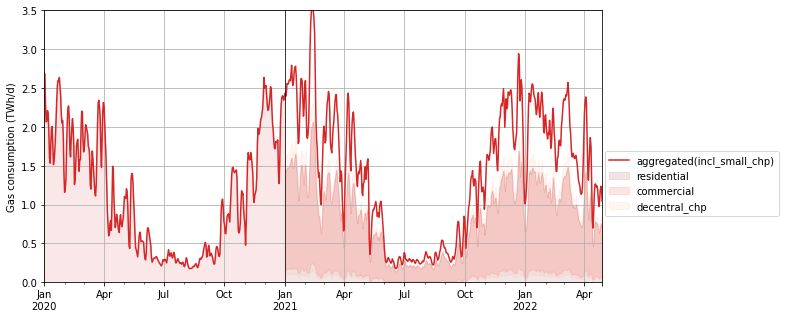

In [18]:
estimated['aggregated(incl_small_chp)'].plot(color='tab:red', figsize=(10,5))
plt.grid()

estimated2020 = estimated[estimated.index.year==2020]['aggregated(incl_small_chp)']
estimated2021 = estimated.loc["2021-01-01":]

plt.fill_between(estimated2020.index, 0, estimated2020, color='tab:red', alpha=0.1)

bottom = 0
for sector, c, label in [("scaled_space_private", "maroon", "residential"), (
    "scaled_space_industry","red", "commercial"), ("scaled_decentral_chp", "lightsalmon", "decentral_chp") ]:
    plt.fill_between(estimated2021.index, bottom, estimated2021[sector], color=c, alpha=0.1, label = label)
    bottom += estimated2021[sector]

plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.legend(loc='upper right', bbox_to_anchor=(1.325, 0.5))
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas for electricity generation

In [19]:
electricity_from_gas = pd.read_csv(os.path.join(data_path, "electricity_from_gas.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]

electricity_from_gas = electricity_from_gas /10**6

Scaled to 185 TWh in 2020, which is the sum of public power plants, public CHP, and industrial power plants (probably also mostly CHP):

In [20]:
gas_to_electricity = electricity_from_gas * 189 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

gas_to_electricity_public_pp = electricity_from_gas * 106 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

gas_to_electricity_public_chp = electricity_from_gas * 34 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

gas_to_electricity.name = "gas_to_electricity"

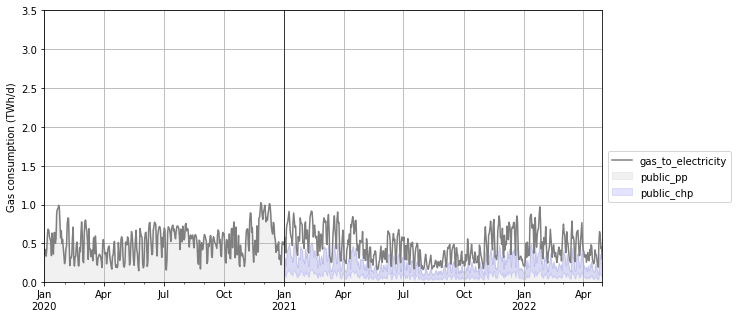

In [21]:
gas_to_electricity.plot(color='tab:grey', figsize=(10,5))
plt.grid()
power2020 = gas_to_electricity[gas_to_electricity.index.year==2020]
index_21_22 = gas_to_electricity[gas_to_electricity.index.year!=2020].index

plt.fill_between(power2020.index, 0, power2020, color='tab:grey', alpha=0.1)
plt.fill_between(index_21_22, 0, gas_to_electricity_public_pp[index_21_22], color='grey', alpha=0.1, label="public_pp")
plt.fill_between(index_21_22, gas_to_electricity_public_pp[index_21_22], gas_to_electricity_public_chp[index_21_22], color='blue', alpha=0.1, label="public_chp")


plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.5))
plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas prices

In [22]:
gas_prices = pd.read_csv(os.path.join(data_path, "Dutch TTF Natural Gas Futures Recent.csv"), index_col=0)
gas_prices = gas_prices["Price"].to_frame().rename(columns={
    "Price":"gas_price [€/MWh]"}).dropna()
gas_prices.index = pd.to_datetime(gas_prices.index, utc = True).date

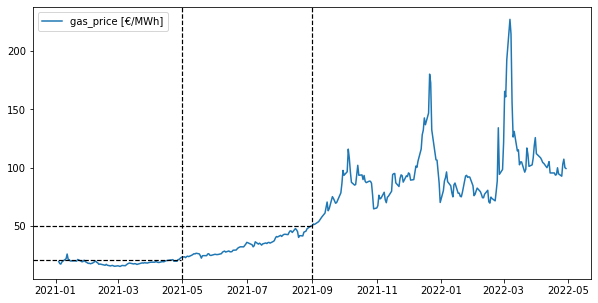

In [23]:
gas_prices.plot(figsize=(10,5))
plt.axvline(x="2021-09-1", color='k', linestyle='--', lw=1.2)
plt.axvline(x="2021-05-1", color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.5, y=50, color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.265, y=21, color='k', linestyle='--', lw=1.2)

Combine sources

In [24]:
df_all = pd.concat(
    [
        estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry","scaled_district_heat", 'aggregated(incl_small_chp)']
                                                   ], 
     the_whole_slp, the_whole_rlm, bdew, gas_to_electricity, electricity_from_gas, gas_prices], 
    axis = 1)

In [25]:
first = the_whole_slp.iloc[0].name
last = the_whole_slp.iloc[-1].name

def unify_index(df):
    try:
        return df.loc[(df.index >= first) & (df.index <= last)]
    except:
        return df.loc[(df.index.date >= first) & (df.index.date <= last)]

In [26]:
df_all = unify_index(df_all)

In [27]:
df_all

,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,scaled_district_heat,aggregated(incl_small_chp),the_combined_slp,the_combined_rlm,bdew [TWh],gas_to_electricity,electricity_from_gas,gas_price [€/MWh]
2016-10-01,NaN,NaN,NaN,NaN,NaN,NaN,0.396332,1.262703,NaN,NaN,NaN,NaN
2016-10-02,NaN,NaN,NaN,NaN,NaN,NaN,0.511865,1.229047,NaN,NaN,NaN,NaN
2016-10-03,NaN,NaN,NaN,NaN,NaN,NaN,0.616591,1.300171,NaN,NaN,NaN,NaN
2016-10-04,NaN,NaN,NaN,NaN,NaN,NaN,0.709381,1.546009,NaN,NaN,NaN,NaN
2016-10-05,NaN,NaN,NaN,NaN,NaN,NaN,0.882730,1.629043,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,NaN,NaN,NaN,NaN,NaN,NaN,0.875771,1.364176,NaN,0.453907,0.141998,99.45
2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN,0.875211,1.139229,NaN,0.292613,0.091540,NaN
2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,0.870934,1.099974,NaN,NaN,NaN,NaN
2022-05-02,NaN,NaN,NaN,NaN,NaN,NaN,0.824349,0.000000,NaN,NaN,NaN,NaN


# Analysis & plotting

## Align indexes
All calculations and plots are done for the same period: 01.10.2021-25.03.2022

# Subtract gas for electricity generation

## THE vs. our estimates

In [28]:
y1=df_all["aggregated(incl_small_chp)"]
y2= df_all["the_combined_slp"]
y3 = df_all["the_combined_rlm"]

### Weekly analyis: Russian invasion: 24.02. (Thu), Fasching: 28.02.-02.03. (Mon-Wed)

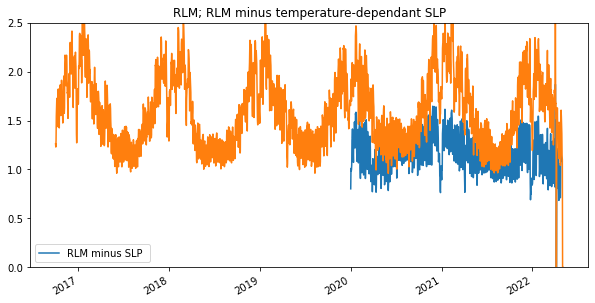

In [29]:
ax = (y3 - 0.34*y1).to_frame().rename(columns={0:"RLM minus SLP "}).plot()
ax.set_ylim(0,2.5)
y3.plot(
    ax=ax, title = "RLM; RLM minus temperature-dependant SLP", figsize=(10,5))
plt.show()

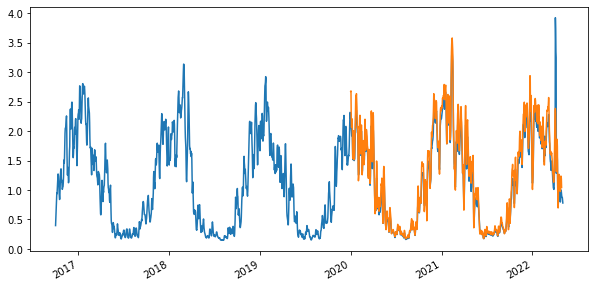

In [30]:
ax = y2.plot()
y1.plot(ax=ax, figsize=(10,5))

plt.show()

# Export

In [31]:
df = df_all

In [32]:
df['index']= df.index
df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df["index"].apply(lambda x: x.year)
df['month'] = df['index'].apply(lambda x: x.month)

In [33]:
df['weekday'] = df['index'].apply(lambda x: x.strftime('%A'))
df['weekday_num'] = df['index'].apply(lambda x: x.weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

In [34]:
df['christmas_period'] = df['index'].apply(
    lambda x: int((x.month==12)&(x.day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['index'].apply(lambda x: int(x in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)

In [35]:
df

,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,scaled_district_heat,aggregated(incl_small_chp),the_combined_slp,the_combined_rlm,bdew [TWh],gas_to_electricity,...,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2016-10-01,NaN,NaN,NaN,NaN,NaN,NaN,0.396332,1.262703,NaN,NaN,...,2016,10,Saturday,5,0,0,1,0,0,0
2016-10-02,NaN,NaN,NaN,NaN,NaN,NaN,0.511865,1.229047,NaN,NaN,...,2016,10,Sunday,6,0,0,1,0,0,0
2016-10-03,NaN,NaN,NaN,NaN,NaN,NaN,0.616591,1.300171,NaN,NaN,...,2016,10,Monday,0,1,0,0,0,1,0
2016-10-04,NaN,NaN,NaN,NaN,NaN,NaN,0.709381,1.546009,NaN,NaN,...,2016,10,Tuesday,1,0,0,0,0,0,0
2016-10-05,NaN,NaN,NaN,NaN,NaN,NaN,0.882730,1.629043,NaN,NaN,...,2016,10,Wednesday,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,NaN,NaN,NaN,NaN,NaN,NaN,0.875771,1.364176,NaN,0.453907,...,2022,4,Friday,4,0,1,0,0,0,0
2022-04-30,NaN,NaN,NaN,NaN,NaN,NaN,0.875211,1.139229,NaN,0.292613,...,2022,4,Saturday,5,0,0,1,0,0,0
2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,0.870934,1.099974,NaN,NaN,...,2022,5,Sunday,6,0,0,1,0,1,0
2022-05-02,NaN,NaN,NaN,NaN,NaN,NaN,0.824349,0.000000,NaN,NaN,...,2022,5,Monday,0,1,0,0,0,0,0


In [36]:
df.to_csv(os.path.join(data_path, "preprocessed.csv"))